## Introducción
Se realizó Regresión Lineal, Ridge y Lasso para predecir el valor de cierre (gold close) del oro.

## Inicio 

Se descarga el dataset en cuestión, se elimina las filas que tengan un valor nulo en la variable objetivo, se elimina la columna correspondiente a la fecha (date) y el resto de valores nulos se reemplazan con la media de la columna. No se eliminaron todas las filas que contuvieran algún valor nulo debido a que se pasaba de tener 4000 datos a 300 (aproximadamente). 

In [13]:
import kagglehub 
import numpy as np
import pandas as panda
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.metrics import r2_score
r2 = []
maes = []
mses = []

np.set_printoptions(suppress=True, precision=6)
path = kagglehub.dataset_download("franciscogcc/financial-data")
path = os.path.join(path, "financial_regression.csv")
dataset = panda.read_csv(path)
dataset = dataset.dropna(subset=["gold close"])
#Si elimino todas las filas que tengan algún valor nulo se eliminan casi todas
#dataset = dataset.dropna()
dataset = dataset.drop(["date"], axis=1)
dataset = dataset.fillna(dataset.mean())

panda.set_option('display.max_rows', 20)     
panda.set_option('display.max_columns', 10) 
print(dataset)
panda.set_option('display.max_rows', None)     
panda.set_option('display.max_columns', None) 
#sns.pairplot(dataset)

      sp500 open  sp500 high  sp500 low  sp500 close  sp500 volume  ...  gold open  gold high  gold low  gold close  gold volume
0         114.49    115.1400   114.4200       114.93   115646960.0  ...     111.51     112.37    110.79      112.03   18305238.0
1         114.73    114.8400   113.2000       113.64   212252769.0  ...     111.35     112.01    110.38      110.86   18000724.0
3         113.62    115.1300   113.5900       115.06   138671890.0  ...     110.95     111.75    110.83      111.52   10467927.0
4         114.28    114.4500   112.9800       113.89   216330645.0  ...     109.97     110.05    108.46      108.94   17534231.0
5         113.92    114.2700   111.5600       111.70   344747028.0  ...     108.48     108.78    106.61      107.37   25747831.0
...          ...         ...        ...          ...           ...  ...        ...        ...       ...         ...          ...
3899      585.91    586.1200   582.1600       582.35    34393714.0  ...     247.75     249.06    

## Gráficos iniciales, separación del dataset, correlación y normalización  

Se hizo una matriz de correlación teniendo a la variable objetivo (gold close) como columna y a todas las variables como filas. Con esto se pudo observar que habían 3 variables muy correlacionadas: "gold low", "gold high" y "gold open". Tanto así que el valor obtenido era casi 1.  

Posteriormente, se realizó un gráfico para observar la distribución de la variable objetivo y un histograma de la misma. 

Además, se graficaron las 3 variables mencionadas anteriormente y "oil close" con respecto a la variable objetivo. Se pudo observar que las 3 primeras tenían un comportamiento prácticamente lineal, mientras que "oil close" mantenía algo de linealidad pero se comportaba bastante diferente. 

Por último, se separó el dataset en train y test. Dejando un test de 1116 filas y un train de 2603 aproximadamente. Luego, se normalizaron los valores de las columnas para mantenerlos de un margen adecuado. 

gold close            1.000000
gold low              0.999764
gold high             0.999743
gold open             0.999463
oil close             0.754307
oil high              0.754081
oil low               0.754048
oil open              0.753937
nasdaq high           0.738573
nasdaq open           0.738189
nasdaq close          0.738153
nasdaq low            0.737749
sp500 high            0.681964
sp500 close           0.681309
sp500 open            0.681244
sp500 low             0.680525
silver low            0.601549
silver close          0.601086
silver open           0.600088
silver high           0.599920
silver volume         0.580832
nasdaq high-low       0.557646
oil high-low          0.552383
palladium high        0.440820
palladium open        0.439334
palladium close       0.439038
palladium low         0.437356
platinum volume       0.418378
sp500 high-low        0.414887
palladium high-low    0.350614
silver high-low       0.340583
platinum high-low     0.228839
CPI     

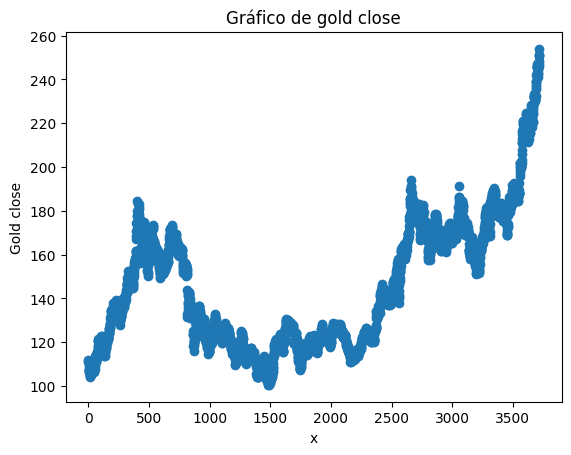

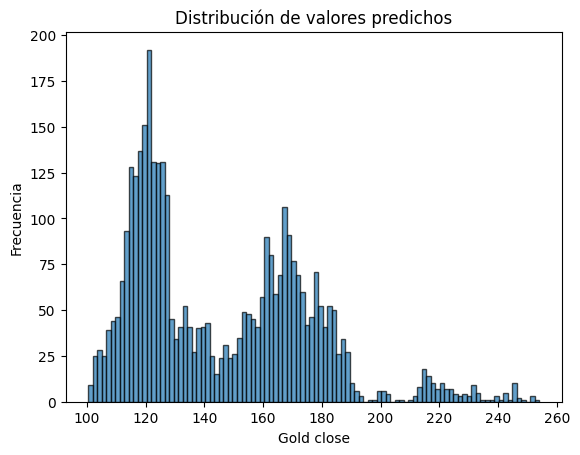

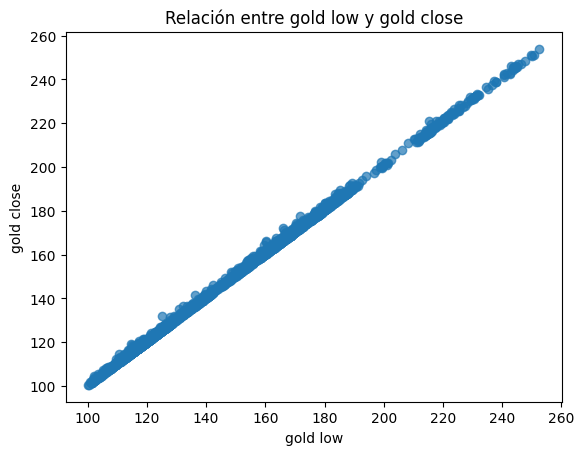

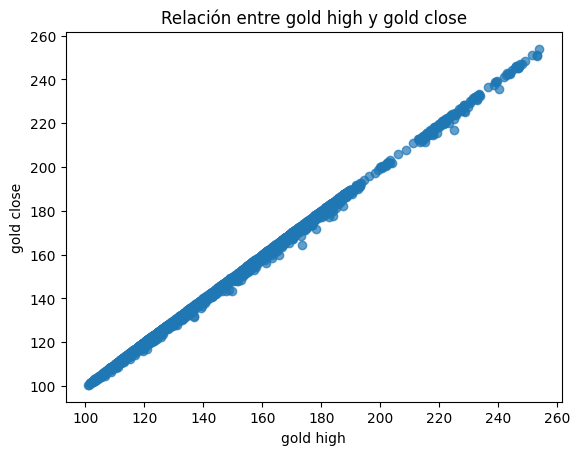

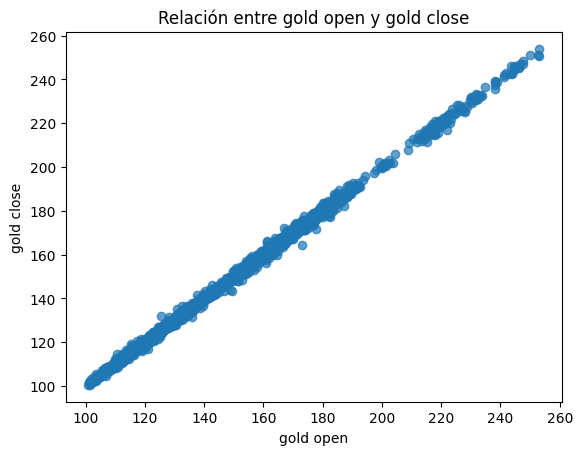

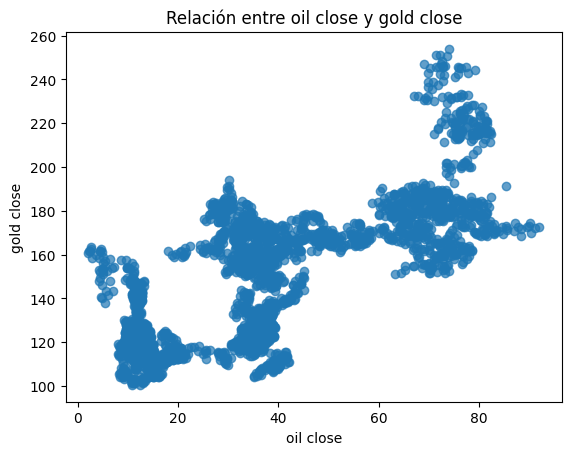

In [14]:
x = dataset.drop(["gold close"], axis=1)
y = dataset["gold close"]

#corrMatrix = dataset.corr()
#print(corrMatrix)
corrGold = dataset.corr()['gold close'].sort_values(ascending=False)
print(corrGold)

plt.scatter(range(len(y)), y)
plt.xlabel('x')
plt.ylabel('Gold close')
plt.title('Gráfico de gold close')
plt.show()

plt.hist(y, bins=100, edgecolor='black', alpha=0.7)
plt.xlabel("Gold close")
plt.ylabel("Frecuencia")
plt.title("Distribución de valores predichos")
plt.show()

plt.scatter(dataset["gold low"], dataset["gold close"], alpha=0.7)
plt.xlabel("gold low")
plt.ylabel("gold close")
plt.title("Relación entre gold low y gold close")
plt.show()

plt.scatter(dataset["gold high"], dataset["gold close"], alpha=0.7)
plt.xlabel("gold high")
plt.ylabel("gold close")
plt.title("Relación entre gold high y gold close")
plt.show()

plt.scatter(dataset["gold open"], dataset["gold close"], alpha=0.7)
plt.xlabel("gold open")
plt.ylabel("gold close")
plt.title("Relación entre gold open y gold close")
plt.show()

plt.scatter(dataset["oil close"], dataset["gold close"], alpha=0.7)
plt.xlabel("oil close")
plt.ylabel("gold close")
plt.title("Relación entre oil close y gold close")
plt.show()

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=2025)
scaler = StandardScaler()
xtrainScaled = scaler.fit_transform(xtrain)
xtestScaled = scaler.transform(xtest)

## Linear Regression con todas las variables  
Se utilizo Linear Regression para hacer un modelo con todas las variables y con dicho modelo se calcularon los coeficientes, el MSE (Mean Squared Error), el MAE (Mean Absolute Error) y el R2 (coeficiente de determinación). Por último, se realizó un gráfico que muestra que tan cercanas estuvieron las predicciones con el valor ideal o correcto.

Coeficientes encontrados: [  1.414495   0.554196   0.561255  -2.468992   0.033166  -0.040873
  -2.012963   0.625088   0.634212   0.679363  -0.007867   0.04045
  -0.000397   0.0011    -0.006622   0.002997   0.0026     5.33919
  -7.473758  -7.740585   9.880631  -0.022132   0.007287   0.334653
   0.044824   0.046135  -0.441551   0.005291  -0.009908   3.448119
  -5.295172  -5.329845   7.194821   0.005276  -0.007305   0.459839
  -0.642366  -0.659908   0.853608   0.003371   0.006383 -17.030636
  24.338621  22.885102  -0.035611]
MSE  0.07655332810156008
MAE  0.1940025595948496
R2:  0.999904016193277


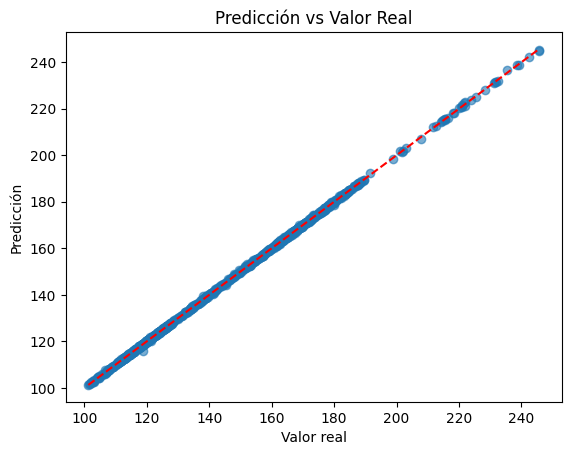

In [15]:
model = LinearRegression()
model.fit(xtrainScaled, ytrain)

prediction = model.predict(xtestScaled)
print("Coeficientes encontrados:", model.coef_)
print("MSE ", mean_squared_error(ytest, prediction))
print("MAE ", mean_absolute_error(ytest, prediction))
print("R2: ", r2_score(ytest, prediction))
mses.append(mean_squared_error(ytest, prediction))
r2.append(r2_score(ytest, prediction))
maes.append(mean_absolute_error(ytest, prediction))

plt.scatter(ytest, prediction, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor Real")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')  # Línea ideal
plt.show()

## Linear Regression con las 3 mejores variables
Se utilizo Linear Regression para hacer un modelo con las 3 mejores variables y con dicho modelo se calcularon los coeficientes, el MSE (Mean Squared Error), el MAE (Mean Absolute Error) y el R2 (coeficiente de determinación). Por último, se realizó un gráfico que muestra que tan cercanas estuvieron las predicciones con el valor ideal o correcto.

Coeficientes encontrados: [-18.603398  23.643958  25.124269]
MSE  0.15413012045781085
MAE  0.2814050330266518
R2:  0.9998067491504407


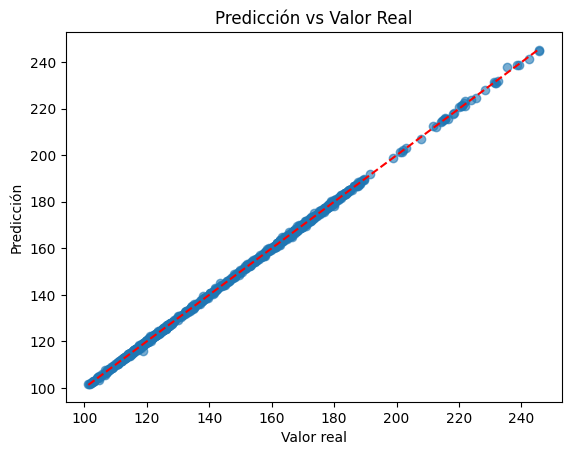

In [16]:
xtrainaux = xtrain[["gold open", "gold low", "gold high"]]
xtestaux = xtest[["gold open", "gold low", "gold high"]]
xtrainaux = scaler.fit_transform(xtrainaux)
xtestaux = scaler.transform(xtestaux)
model = LinearRegression()
model.fit(xtrainaux, ytrain)

prediction = model.predict(xtestaux)
print("Coeficientes encontrados:", model.coef_)
print("MSE ", mean_squared_error(ytest, prediction))
print("MAE ", mean_absolute_error(ytest, prediction))
print("R2: ", r2_score(ytest, prediction))
mses.append(mean_squared_error(ytest, prediction))
r2.append(r2_score(ytest, prediction))
maes.append(mean_absolute_error(ytest, prediction))

plt.scatter(ytest, prediction, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor Real")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')  # Línea ideal
plt.show()

## Linear Regression con todas las variables exceptuando las 3 mejores
Se utilizo Linear Regression para hacer un modelo con todas las variables menos las 3 mejores y con dicho modelo se calcularon los coeficientes, el MSE (Mean Squared Error), el MAE (Mean Absolute Error) y el R2 (coeficiente de determinación). Por último, se realizó un gráfico que muestra que tan cercanas estuvieron las predicciones con el valor ideal o correcto.

Coeficientes encontrados: [ 47.778301 -36.245554 -36.723832   3.888354   0.42991    3.454932
 -22.465352  19.210761  19.532751  20.683992  -2.550404  -0.619485
   0.559157  -0.612711  -0.22063   -1.803876   0.088401 -15.336377
  22.095182  22.927939 -12.056156  -1.032914  -0.776049  19.180379
 -18.372424 -18.771161  22.591185   0.940903  -0.386188  28.480428
 -39.894855 -40.15676   48.842355   1.626729  -0.027771   0.500466
 -19.928884 -20.498014  38.186458  -1.04591    0.79255    1.136147]
MSE  63.89342277732729
MAE  6.230071615977003
R2:  0.9198893882889578


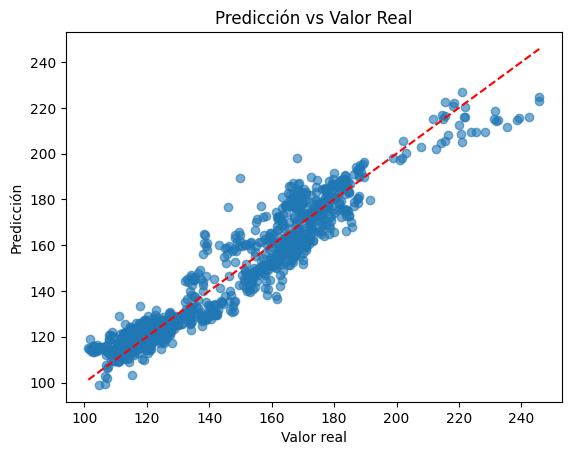

In [17]:
xtrainaux = xtrain.drop(["gold open", "gold low", "gold high"], axis=1)
xtestaux = xtest.drop(["gold open", "gold low", "gold high"], axis=1)
xtrainaux = scaler.fit_transform(xtrainaux)
xtestaux = scaler.transform(xtestaux)
model = LinearRegression()
model.fit(xtrainaux, ytrain)

prediction = model.predict(xtestaux)
print("Coeficientes encontrados:", model.coef_)
print("MSE ", mean_squared_error(ytest, prediction))
print("MAE ", mean_absolute_error(ytest, prediction))
print("R2: ", r2_score(ytest, prediction))
mses.append(mean_squared_error(ytest, prediction))
r2.append(r2_score(ytest, prediction))
maes.append(mean_absolute_error(ytest, prediction))

plt.scatter(ytest, prediction, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor Real")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')  # Línea ideal
plt.show()

## Ridge con todas las variables  
Se utilizo Ridge para hacer un modelo con todas las variables y con dicho modelo se calcularon los coeficientes, el MSE (Mean Squared Error), el MAE (Mean Absolute Error) y el R2 (coeficiente de determinación). Además, se probaron algunos valores de alpha para encontrar el más adecuado. Por último, se realizó un gráfico que muestra que tan cercanas estuvieron las predicciones con el valor ideal o correcto.  

Con respecto a los coeficientes, se puede observar como los correspondientes a variables menos importantes son acercados a 0 (sin llegar a 0).

Coeficientes encontrados: [  1.418123   0.532297   0.53911   -2.428022   0.033233  -0.040834
  -1.996038   0.628429   0.637606   0.655301  -0.007844   0.040462
  -0.000392   0.001227  -0.006545   0.003038   0.002572   5.272865
  -7.431941  -7.697292   9.861717  -0.021929   0.007556   0.348983
   0.032275   0.033305  -0.430439   0.005392  -0.009939   3.388752
  -5.253736  -5.288138   7.171033   0.005085  -0.007225   0.467903
  -0.65309   -0.670921   0.867279   0.003343   0.006391 -16.892804
  24.26403   22.821728  -0.035691]
Mejor alpha: 0.001
MSE  0.07652461361316498
MAE  0.19407247988676007
R2:  0.9999040521959691


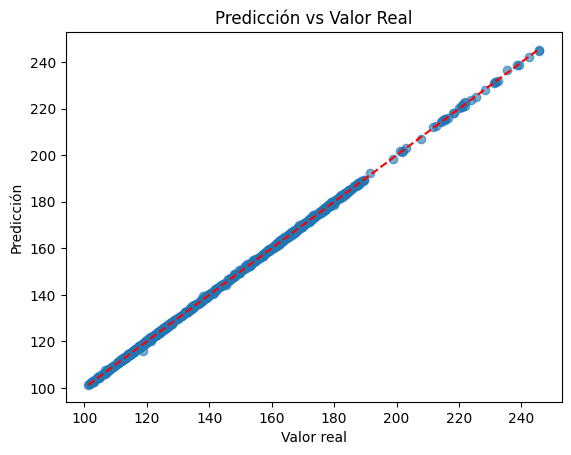

In [18]:

alphas = [0.001, 0.01, 0.1, 1, 5, 10, 15, 30, 50]
model = RidgeCV(alphas=alphas)
model.fit(xtrainScaled, ytrain)

prediction = model.predict(xtestScaled)

print("Coeficientes encontrados:", model.coef_)
print("Mejor alpha:", model.alpha_)
print("MSE ", mean_squared_error(ytest, prediction))
print("MAE ", mean_absolute_error(ytest, prediction))
print("R2: ", r2_score(ytest, prediction))
mses.append(mean_squared_error(ytest, prediction))
r2.append(r2_score(ytest, prediction))
maes.append(mean_absolute_error(ytest, prediction))

plt.scatter(ytest, prediction, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor Real")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')  # Línea ideal
plt.show()

## Ridge con las 3 variables más importantes
Se utilizo Ridge para hacer un modelo con las 3 variables más importantes y con dicho modelo se calcularon los coeficientes, el MSE (Mean Squared Error), el MAE (Mean Absolute Error) y el R2 (coeficiente de determinación). Además, se probaron algunos valores de alpha para encontrar el más adecuado. Por último, se realizó un gráfico que muestra que tan cercanas estuvieron las predicciones con el valor ideal o correcto.  

Con respecto a los coeficientes, se puede observar como los correspondientes a variables menos importantes son acercados a 0 (sin llegar a 0).

Coeficientes encontrados: [-18.551789  23.624056  25.092557]
Mejor alpha: 0.001
MSE  0.15409252191089853
MAE  0.2814030270243806
R2:  0.9998067962921098


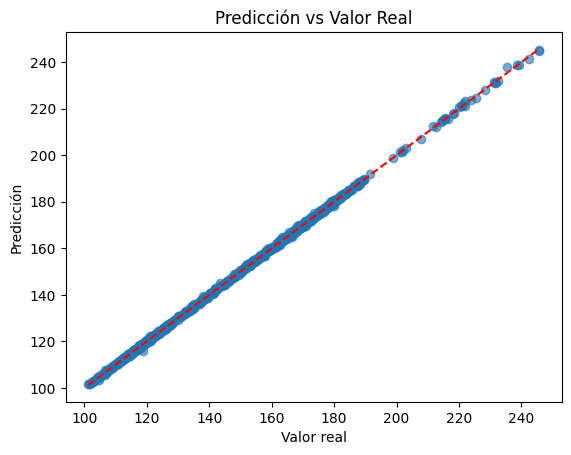

In [19]:
xtrainaux = xtrain[["gold open", "gold low", "gold high"]]
xtestaux = xtest[["gold open", "gold low", "gold high"]]
xtrainaux = scaler.fit_transform(xtrainaux)
xtestaux = scaler.transform(xtestaux)
model = RidgeCV(alphas=alphas)
model.fit(xtrainaux, ytrain)

prediction = model.predict(xtestaux)
print("Coeficientes encontrados:", model.coef_)
print("Mejor alpha:", model.alpha_)
print("MSE ", mean_squared_error(ytest, prediction))
print("MAE ", mean_absolute_error(ytest, prediction))
print("R2: ", r2_score(ytest, prediction))
mses.append(mean_squared_error(ytest, prediction))
r2.append(r2_score(ytest, prediction))
maes.append(mean_absolute_error(ytest, prediction))

plt.scatter(ytest, prediction, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor Real")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')  # Línea ideal
plt.show()

## Ridge con todas las variables excepto las 3 más importantes
Se utilizo Ridge para hacer un modelo con todas las variables menos las 3 más importantes y con dicho modelo se calcularon los coeficientes, el MSE (Mean Squared Error), el MAE (Mean Absolute Error) y el R2 (coeficiente de determinación). Además, se probaron algunos valores de alpha para encontrar el más adecuado. Por último, se realizó un gráfico que muestra que tan cercanas estuvieron las predicciones con el valor ideal o correcto.  

Con respecto a los coeficientes, se puede observar como los correspondientes a variables menos importantes son acercados a 0 (sin llegar a 0).

Coeficientes encontrados: [  9.459632 -14.625273 -14.86235   -1.30471    0.422077   3.4632
   3.394984   6.563461   6.68346   20.373569  -2.513423  -0.659047
   0.553845  -0.620815  -0.221138  -1.803928   0.098483  -5.83422
  11.842194  12.311135  -0.665172  -1.037824  -0.804424  11.328831
  -9.581687  -9.784961  12.626753   0.926819  -0.351905  11.746492
 -21.214029 -21.353641  28.075765   1.63117   -0.000784  -2.88266
 -14.35834  -14.779631  30.251594  -1.03145    0.839585   1.132913]
Mejor alpha: 0.1
MSE  63.736388943907855
MAE  6.22355205984702
R2:  0.9200862798610122


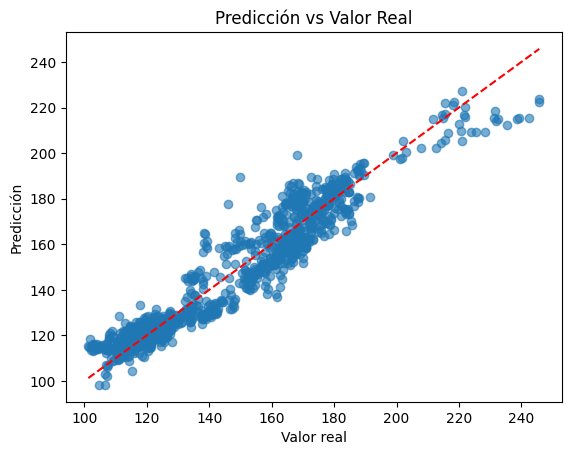

In [20]:
xtrainaux = xtrain.drop(["gold open", "gold low", "gold high"], axis=1)
xtestaux = xtest.drop(["gold open", "gold low", "gold high"], axis=1)
xtrainaux = scaler.fit_transform(xtrainaux)
xtestaux = scaler.transform(xtestaux)
model = RidgeCV(alphas=alphas)
model.fit(xtrainaux, ytrain)

prediction = model.predict(xtestaux)
print("Coeficientes encontrados:", model.coef_)
print("Mejor alpha:", model.alpha_)
print("MSE ", mean_squared_error(ytest, prediction))
print("MAE ", mean_absolute_error(ytest, prediction))
print("R2: ", r2_score(ytest, prediction))
mses.append(mean_squared_error(ytest, prediction))
r2.append(r2_score(ytest, prediction))
maes.append(mean_absolute_error(ytest, prediction))

plt.scatter(ytest, prediction, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor Real")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')  # Línea ideal
plt.show()

## Lasso con todas las variables  
Se utilizo Lasso para hacer un modelo con todas las variables y con dicho modelo se calcularon los coeficientes, el MSE (Mean Squared Error), el MAE (Mean Absolute Error) y el R2 (coeficiente de determinación). Además, se probaron algunos valores de alpha para encontrar el más adecuado. Por último, se realizó un gráfico que muestra que tan cercanas estuvieron las predicciones con el valor ideal o correcto.  

Con respecto a los coeficientes, se puede observar como los correspondientes a variables menos importantes son acercados a 0 o incluso llegan a ser 0.

Coeficientes encontrados: [ 0.023721  0.        0.        0.        0.004696 -0.040315  0.
  0.        0.        0.        0.043201  0.017739 -0.003951  0.013164
  0.000029  0.        0.00398  -4.258932 -1.855068 -0.028485  6.17078
  0.004638  0.002071 -0.       -0.       -0.049181 -0.        0.013623
 -0.       -2.30337  -0.       -0.        2.31449  -0.014671 -0.036745
  0.        0.        0.        0.014956  0.022546  0.014186 -0.000484
 22.250962  7.921021 -0.135468]
Mejor alpha: 0.001
MSE  0.1500601703728858
MAE  0.27156301089507073
R2:  0.9998118521199916


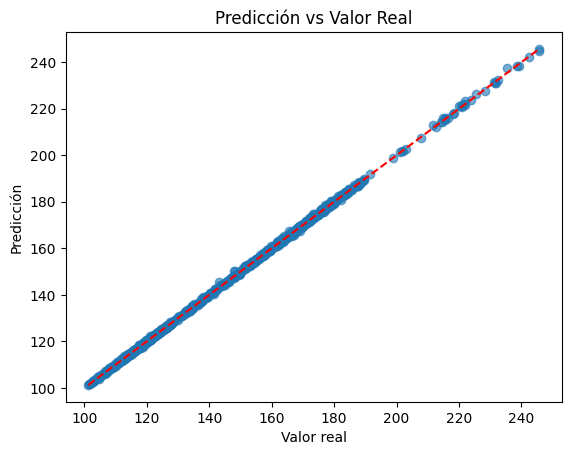

In [21]:
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 15, 30, 50]
model = LassoCV(alphas=alphas, max_iter=100000)
model.fit(xtrainScaled, ytrain)

prediction = model.predict(xtestScaled)
print("Coeficientes encontrados:", model.coef_)
print("Mejor alpha:", model.alpha_)
print("MSE ", mean_squared_error(ytest, prediction))
print("MAE ", mean_absolute_error(ytest, prediction))
print("R2: ", r2_score(ytest, prediction))
mses.append(mean_squared_error(ytest, prediction))
r2.append(r2_score(ytest, prediction))
maes.append(mean_absolute_error(ytest, prediction))

plt.scatter(ytest, prediction, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor Real")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')  # Línea ideal
plt.show()

## Lasso con las 3 variables más importantes 
Se utilizo Lasso para hacer un modelo con las 3 variables más importantes y con dicho modelo se calcularon los coeficientes, el MSE (Mean Squared Error), el MAE (Mean Absolute Error) y el R2 (coeficiente de determinación). Además, se probaron algunos valores de alpha para encontrar el más adecuado. Por último, se realizó un gráfico que muestra que tan cercanas estuvieron las predicciones con el valor ideal o correcto.  

Con respecto a los coeficientes, se puede observar como los correspondientes a variables menos importantes son acercados a 0 o incluso llegan a ser 0.

Coeficientes encontrados: [-9.196238 23.021731 16.340168]
Mejor alpha: 0.001
MSE  0.190095605378545
MAE  0.3119302883575017
R2:  0.9997616550410278


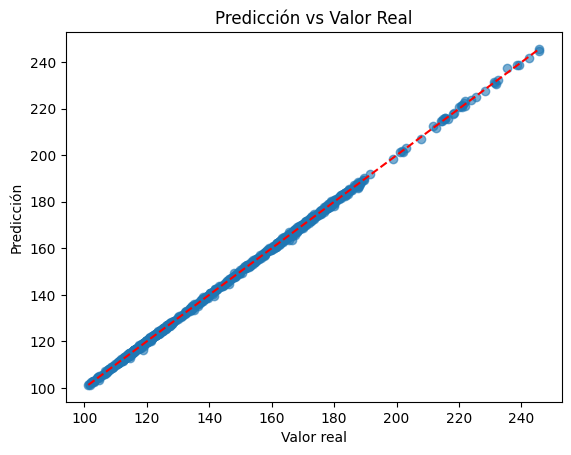

In [22]:
xtrainaux = xtrain[["gold open", "gold low", "gold high"]]
xtestaux = xtest[["gold open", "gold low", "gold high"]]
xtrainaux = scaler.fit_transform(xtrainaux)
xtestaux = scaler.transform(xtestaux)
model = LassoCV(alphas=alphas, max_iter=100000)
model.fit(xtrainaux, ytrain)

prediction = model.predict(xtestaux)
print("Coeficientes encontrados:", model.coef_)
print("Mejor alpha:", model.alpha_)
print("MSE ", mean_squared_error(ytest, prediction))
print("MAE ", mean_absolute_error(ytest, prediction))
print("R2: ", r2_score(ytest, prediction))
mses.append(mean_squared_error(ytest, prediction))
r2.append(r2_score(ytest, prediction))
maes.append(mean_absolute_error(ytest, prediction))

plt.scatter(ytest, prediction, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor Real")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')  # Línea ideal
plt.show()

## Lasso con todas las variables excepto las 3 más importantes 
Se utilizo Lasso para hacer un modelo con todas las variables menos las 3 más importantes y con dicho modelo se calcularon los coeficientes, el MSE (Mean Squared Error), el MAE (Mean Absolute Error) y el R2 (coeficiente de determinación). Además, se probaron algunos valores de alpha para encontrar el más adecuado. Por último, se realizó un gráfico que muestra que tan cercanas estuvieron las predicciones con el valor ideal o correcto.  

Con respecto a los coeficientes, se puede observar como los correspondientes a variables menos importantes son acercados a 0 o incluso llegan a ser 0.

Coeficientes encontrados: [  0.       -19.327057  -1.955505  -0.         0.421367   3.618134
  11.54661    0.         0.        25.327906  -2.493479  -0.630778
   0.540368  -0.610695  -0.209389  -1.793796   0.095835  -0.80821
  10.987758   5.747513   1.854502  -1.044076  -0.979231   2.405456
  -0.        -0.         2.158363   0.928796  -0.317766   3.540776
 -27.826452  -2.028955  23.477808   1.633193   0.326129  -0.196848
 -27.81814   -4.633056  30.568268  -1.036193   1.318508   1.135987]
Mejor alpha: 0.001
MSE  63.75655689823468
MAE  6.222166218859714
R2:  0.9200609929521592


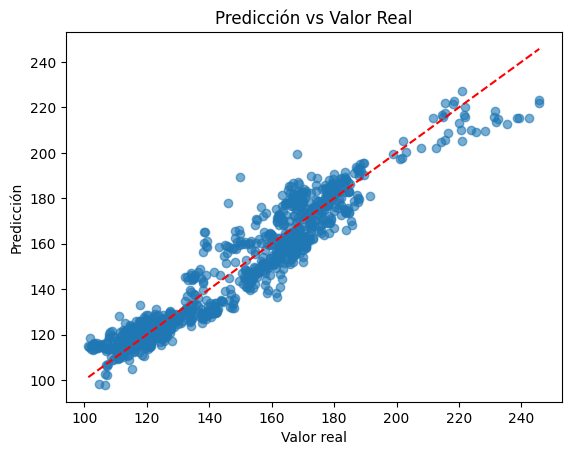

In [23]:
xtrainaux = xtrain.drop(["gold open", "gold low", "gold high"], axis=1)
xtestaux = xtest.drop(["gold open", "gold low", "gold high"], axis=1)
xtrainaux = scaler.fit_transform(xtrainaux)
xtestaux = scaler.transform(xtestaux)
model = LassoCV(alphas=alphas, max_iter=1000000)
model.fit(xtrainaux, ytrain)

prediction = model.predict(xtestaux)
print("Coeficientes encontrados:", model.coef_)
print("Mejor alpha:", model.alpha_)
print("MSE ", mean_squared_error(ytest, prediction))
print("MAE ", mean_absolute_error(ytest, prediction))
print("R2: ", r2_score(ytest, prediction))
mses.append(mean_squared_error(ytest, prediction))
r2.append(r2_score(ytest, prediction))
maes.append(mean_absolute_error(ytest, prediction))

plt.scatter(ytest, prediction, alpha=0.6)
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor Real")
plt.plot([ytest.min(), ytest.max()], [ytest.min(), ytest.max()], 'r--')  # Línea ideal
plt.show()

## Resumen de resultados  
Se realizó una matriz que resume las métricas encontradas para cada caso realizado.

In [24]:
columnas = ["LR TODAS", "LR 3", "LR TODAS - 3", "RIDGE TODAS", "RIDGE 3", "RIDGE TODAS - 3","LASSO TODAS", "LASSO 3", "LASSO TODAS - 3"]

panda.set_option('display.width', 1000)
dataframeAux = panda.DataFrame([maes, mses, r2], index=["MAE", "MSE", "R²"], columns=columnas)
print(dataframeAux)

     LR TODAS      LR 3  LR TODAS - 3  RIDGE TODAS   RIDGE 3  RIDGE TODAS - 3  LASSO TODAS   LASSO 3  LASSO TODAS - 3
MAE  0.194003  0.281405      6.230072     0.194072  0.281403         6.223552     0.271563  0.311930         6.222166
MSE  0.076553  0.154130     63.893423     0.076525  0.154093        63.736389     0.150060  0.190096        63.756557
R²   0.999904  0.999807      0.919889     0.999904  0.999807         0.920086     0.999812  0.999762         0.920061
